In [90]:
import pandas as pd
import math
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from utils.KeyMethods import KeyMethods
import requests
import datetime

In [52]:
df = pd.read_json("gme.json")

# Columns
### Date : date of the stock data
### Open : The price the stock sold for as soon as the markets opened.
### High : The highest price the stock sold for on a particular day.
### Low : The lowest price the stock sold for on a particular day.
### Close : The price the stock sold for as soon as the markets closed.
### Adj Close : The close price after all corporate actions of the day are accounted for (i.e. dividends, splitting, etc.).
### Volume : The number of stocks traded (bought and sold) in a day.


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5600 entries, 0 to 5599
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       5600 non-null   datetime64[ns]
 1   Open       5600 non-null   float64       
 2   High       5600 non-null   float64       
 3   Low        5600 non-null   float64       
 4   Close      5600 non-null   float64       
 5   Adj Close  5600 non-null   float64       
 6   Volume     5600 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 306.4 KB


In [5]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2002-02-13,2.40625,2.51500,2.38125,2.51250,1.691666,76216000
1,2002-02-14,2.54375,2.54875,2.48125,2.50000,1.683250,11021600
2,2002-02-15,2.50000,2.50625,2.46250,2.48750,1.674834,8389600
3,2002-02-19,2.47500,2.47500,2.34375,2.38750,1.607504,7410400
4,2002-02-20,2.40000,2.46875,2.38125,2.46875,1.662210,6892800


In [6]:
df[df['High'] == df['High'].max()]

,Date,Open,High,Low,Close,Adj Close,Volume
4772,2021-01-28,66.25,120.75,28.0625,48.400002,48.400002,235263200


In [7]:
months = {}
averages = {}
for i in range(len(df)):
    date = df.loc[i, 'Date']
    month = date.month
    if month in months.keys():
        high = months[month][0]
        amount = months[month][1]
        months[month] = [high + df.loc[i, 'High'], amount + 1]
    else:
        months[month] = [df.loc[i, 'High'], 1]
               
for month in months.keys():
    averages[month] = months[month][0] / months[month][1]

averageDF = {
    "Jan" : averages[1],
    "Feb" : averages[2],
    "Mar" : averages[3],
    "Apr" : averages[4],
    "May" : averages[5],
    "Jun" : averages[6],
    "Jul" : averages[7],
    "Aug" : averages[8],
    "Sep" : averages[9],
    "Oct" : averages[10],
    "Nov" : averages[11],
    "Dec" : averages[12]
}
    
averageDF = pd.DataFrame(averageDF, index=[0])
averageDF

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
0,8.875343,8.462217,9.877809,9.833973,9.571928,10.514888,9.701705,9.847941,9.799947,9.26952,9.702786,8.784825


<AxesSubplot:xlabel='Volume', ylabel='Low'>

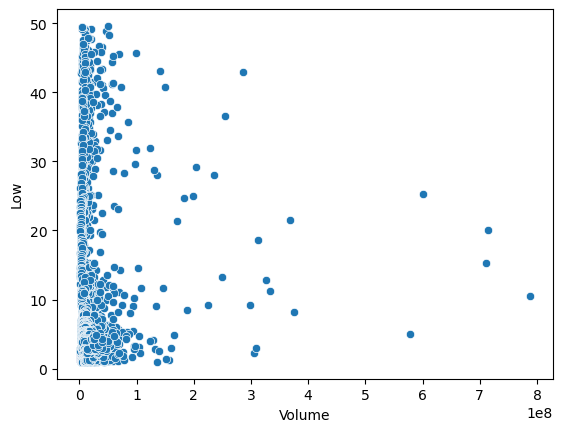

In [8]:
fixedX = KeyMethods.RemoveOutliers(df, "Volume")
fixedDF = KeyMethods.RemoveOutliers(df, "Low")

sns.scatterplot(data = fixedDF, x = "Volume", y = "Low")

In [9]:
KeyMethods.calcCorr(df, "Volume", "Low", 'pearson')

,Volume,Low
Volume,1.000000,-0.000375
Low,-0.000375,1.000000


There is very minimal correlation between the lowest price and the volume traded in that day, with a correlation coefficient around -0.000375. The direction itself is negative, but a clear form or relationship is not present. 

C:\Users\lbarber\AppData\Local\Temp\ipykernel_6780\4209426443.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fixedDF["Log High"] = log_high


<AxesSubplot:xlabel='Date', ylabel='Log High'>

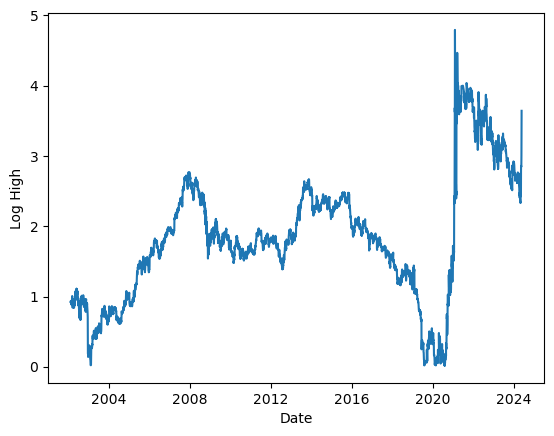

In [14]:
log_high = np.log(fixedDF['High'])

fixedDF["Log High"] = log_high

sns.lineplot(data = fixedDF, x = "Date", y = "Log High")

There is a minimal correlation until 2020 where there is a massive spike followed by a subtle decline. The direction itself is slightly positive, forming a  

In [17]:
df[df['Date'] == df['Date'].max()]

,Date,Open,High,Low,Close,Adj Close,Volume
5599,2024-05-13,26.34,38.200001,24.77,30.450001,30.450001,182308700


In [31]:
years = {}
for date in df['Date']:
    year = date.year
    if year == 2024 : continue
    if year in years.keys():
        years[year] += 1
    else:
        years[year] = 1
    
average = sum(years.values()) / len(years)
average

250.36363636363637

In [128]:
url = 'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol=GME&interval=5min&apikey=U155V14OX0FBGL7B'
r = requests.get(url)
data = r.json()

In [129]:
print(data)

{'Information': 'Thank you for using Alpha Vantage! Our standard API rate limit is 25 requests per day. Please subscribe to any of the premium plans at https://www.alphavantage.co/premium/ to instantly remove all daily rate limits.'}


In [131]:
alphaDF = pd.DataFrame(data['Time Series'])
alphaDF = alphaDF.transpose()
alphaDF.columns = ["Open", "High", "Low", "Close", "Volume"]
alphaDF.insert(0, "Date", alphaDF.index, True)
dates = alphaDF["Date"]
fixedDates = []
for date in dates:
    yearDate = date.split()[0]
    time = date.split()[1]
    ts = pd.Timestamp(year = int(yearDate.split("-")[0]),  month = int(yearDate.split("-")[1]), day = int(yearDate.split("-")[2]), tz = 'US/Central').floor("D")
    fixedDates.append(ts)
alphaDF["Date"] = fixedDates
alphaDF["Date"] = pd.to_datetime(alphaDF['Date']).dt.date
alphaDF

KeyError: 'Time Series'

In [56]:
df = df.drop('Adj Close', axis=1)

In [57]:
df.head()

,Date,Open,High,Low,Close,Volume
0,2002-02-13,2.40625,2.51500,2.38125,2.51250,76216000
1,2002-02-14,2.54375,2.54875,2.48125,2.50000,11021600
2,2002-02-15,2.50000,2.50625,2.46250,2.48750,8389600
3,2002-02-19,2.47500,2.47500,2.34375,2.38750,7410400
4,2002-02-20,2.40000,2.46875,2.38125,2.46875,6892800


In [127]:
df["Date"] = pd.to_datetime(df['Date']).dt.date
conDF = pd.concat([df, alphaDF], ignore_index=True, sort=False)
conDF

,Date,Open,High,Low,Close,Volume
0,2002-02-13,2.40625,2.515,2.38125,2.5125,76216000
1,2002-02-14,2.54375,2.54875,2.48125,2.5,11021600
2,2002-02-15,2.5,2.50625,2.4625,2.4875,8389600
3,2002-02-19,2.475,2.475,2.34375,2.3875,7410400
4,2002-02-20,2.4,2.46875,2.38125,2.46875,6892800
...,...,...,...,...,...,...
5695,2024-09-26,22.3300,22.3498,22.2800,22.3250,30555
5696,2024-09-26,22.2900,22.3500,22.2600,22.3350,34243
5697,2024-09-26,22.2500,22.3200,22.2500,22.2850,21062
5698,2024-09-26,22.2801,22.3204,22.2412,22.2500,30577


In [118]:
days = 0
for date in conDF['Date']:
    year = date.year
    if year != 2024 : continue
    days += 1
days

192